In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout

2024-10-15 00:22:54.730250: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-15 00:22:54.749140: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-15 00:22:54.893234: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-15 00:22:55.028833: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-15 00:22:55.152879: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [3]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

# Then, load the saved weights
model.load_weights('../weights/license_plate_model_weights.h5')

/home/amit/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-10-15 00:22:59.688448: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-10-15 00:22:59.688507: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:135] retrieving CUDA diagnostic information for host: pop-os
2024-10-15 00:22:59.688515: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:142] hostname: pop-os
2024-10-15 00:22:59.688723: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:166] libcuda reported version is: 550.67.0
2024-10-15 00:22:59.688749: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostic

In [4]:
def preprocess_black_plate(image):
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply thresholding to separate white text from black background
    _, binary_image = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY)

    # Apply noise removal using median filtering
    median_filtered = cv2.medianBlur(binary_image, 3)
    
    # Apply morphological operations to clean up the image
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(median_filtered, cv2.MORPH_OPEN, kernel)
    binary_image = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

    return binary_image

In [5]:
def segment_characters(image):
    # Resize the license plate image
    img_lp = cv2.resize(image, (333, 75))
    
    # Preprocess the image for black background and white text
    preprocessed_img = preprocess_black_plate(img_lp)
    
    LP_WIDTH = preprocessed_img.shape[0]
    LP_HEIGHT = preprocessed_img.shape[1]
    
    # Make borders white (since characters are black) to avoid false contour detection at edges
    preprocessed_img[0:3, :] = 255  # Top border
    preprocessed_img[:, 0:3] = 255  # Left border
    preprocessed_img[72:75, :] = 255  # Bottom border
    preprocessed_img[:, 330:333] = 255  # Right border
    
    # Estimate dimensions for contours
    dimensions = [LP_WIDTH/6, LP_WIDTH/2, LP_HEIGHT/10, 2*LP_HEIGHT/3]
    
    # Find contours and segment characters
    char_list = find_contours(dimensions, preprocessed_img)
    
    return char_list

In [6]:
def find_contours(dimensions, img):
    # Invert the image before finding contours (since we're looking for white text now)
    img_inv = cv2.bitwise_not(img)
    cntrs, _ = cv2.findContours(img_inv.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    lower_width, upper_width, lower_height, upper_height = dimensions
    
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    x_cntr_list = []
    img_res = []
    for cntr in cntrs:
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        if lower_width < intWidth < upper_width and lower_height < intHeight < upper_height:
            x_cntr_list.append(intX)
            char_copy = np.zeros((44, 24))
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            # No need to subtract from 255 here, as we want white text on black background
            char_copy[2:42, 2:22] = char
            img_res.append(char_copy)
    
    # Sort characters by x-coordinate
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = [img_res[idx] for idx in indices]
    
    # Display detected contours
    plt.figure()
    plt.imshow(img, cmap='gray')
    plt.title('Character Contours')
    plt.axis('off')
    plt.show()
    
    return np.array(img_res_copy)

In [7]:
# Helper function to format the characters for model input
def fix_dimension(img):
    new_img = np.zeros((28, 28, 3))
    for i in range(3):
        new_img[:, :, i] = img
    return new_img

In [8]:
# Function to show results after character recognition
def show_results(char_list):
    dic = {i: c for i, c in enumerate('0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')}
    output = []
    
    for ch in char_list:
        img = cv2.resize(ch, (28, 28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img)
        img = img.reshape(1, 28, 28, 3)
        y_ = model.predict(img)[0]
        character = dic[np.argmax(y_)]
        output.append(character)
    
    plate_number = ''.join(output)
    return plate_number

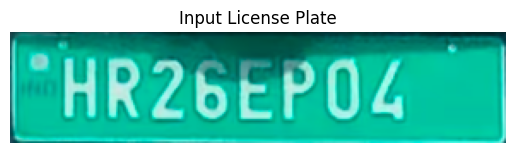

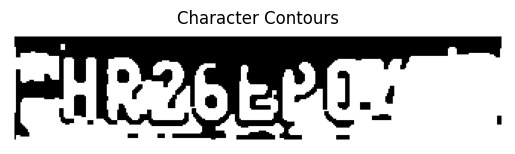

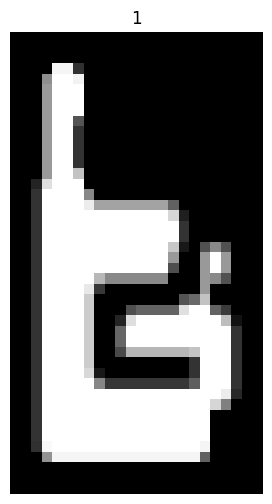

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
Predicted License Plate Number: 6


In [9]:
# Load and process the license plate image
license_plate_img = cv2.imread('../images/input/plate5.png')

# Display the original license plate image
plt.imshow(cv2.cvtColor(license_plate_img, cv2.COLOR_BGR2RGB))
plt.title('Input License Plate')
plt.axis('off')
plt.show()

# Segment characters from the license plate
char_list = segment_characters(license_plate_img)

# Display segmented characters
plt.figure(figsize=(10, 6))
for i, ch in enumerate(char_list):
    plt.subplot(1, len(char_list), i + 1)
    plt.imshow(ch, cmap='gray')
    plt.title(f'{i + 1}')
    plt.axis('off')
plt.show()

# Predict characters
plate_number = show_results(char_list)
print(f"Predicted License Plate Number: {plate_number}")